pacotes necessários

In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.api import VAR
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 18, 12

bases de dados

In [6]:
petr = pd.read_excel('petr4.xlsx')
brent = pd.read_excel('brent.xlsx')

In [7]:
petr.columns = ['data','PETR4 (R$)']
brent.columns = ['data','Brent (US$)']

In [8]:
petr.set_index('data', inplace=True)
brent.set_index('data', inplace=True)

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

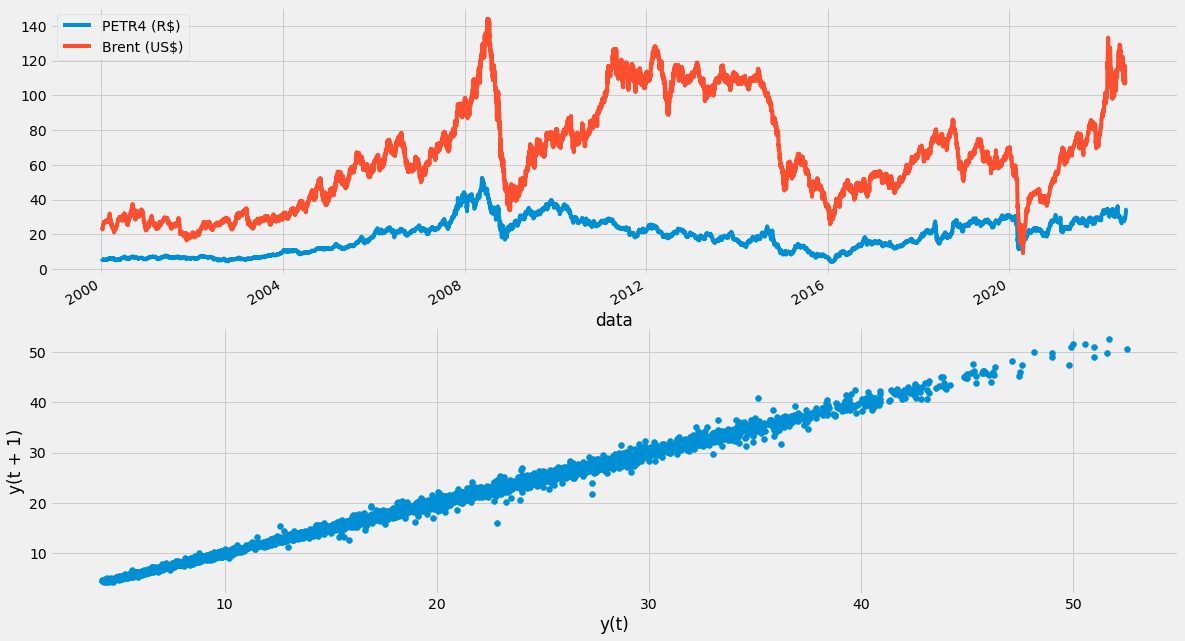

In [9]:
plt.style.use('fivethirtyeight')
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(18, 12))
petr.plot(ax=ax1, label='PETR4 (R$)') #series plot
brent.plot(ax=ax1, label='Brent (US$)')
pd.plotting.lag_plot(petr) #lag plot

teste de estacionaridade

In [10]:
from statsmodels.tsa.stattools import adfuller   


In [15]:
#Determing rolling statistics
def test_stationarity(timeseries):
    rolling_mean = timeseries.rolling(252).mean()
    rolling_std = timeseries.rolling(252).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolling_mean, color='red', label='Média Móvel')
    std = plt.plot(rolling_std, color='black', label = 'Variância Móvel')
    plt.legend(loc='best')
    plt.title('Média Móvel & Variância Móvel')
    plt.show(block=False)

    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

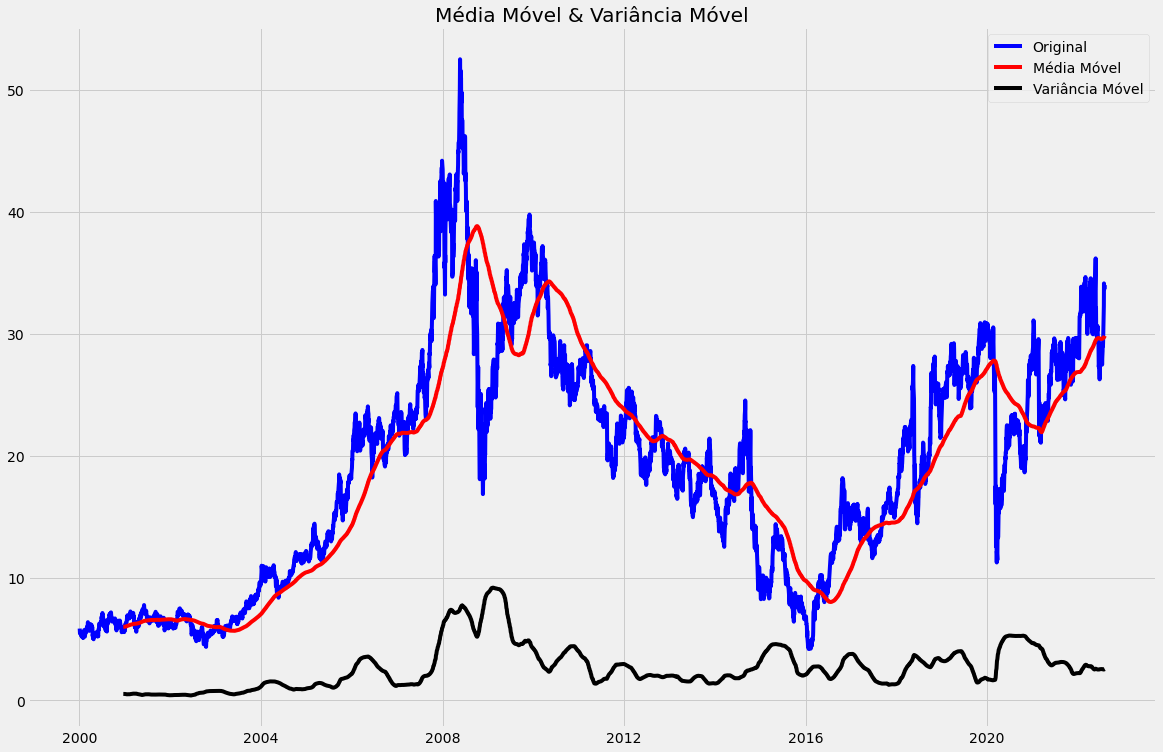

Results of Dickey-Fuller Test:
Test Statistic                   -2.206589
p-value                           0.203863
#Lags Used                       32.000000
Number of Observations Used    5644.000000
Critical Value (1%)              -3.431509
Critical Value (5%)              -2.862052
Critical Value (10%)             -2.567043
dtype: float64


In [16]:
test_stationarity(petr)

Fazendo da série uma estacionária (Diferenciação)

In [22]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(petr['PETR4 (R$)'].diff().dropna())

teste adfuller após diferenciação

In [24]:
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
    

ADF Statistic: -12.233487
p-value: 0.000000
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


Arima

In [31]:
#AR Model
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(petr['PETR4 (R$)'], order=(2,1,0))
results_AR = model.fit(disp=-1)
plt.plot(petr['PETR4 (R$)'], color='blue', label='Original')
plt.plot(results_AR.fittedvalues, color='red', label='AR Model')
plt.legend(loc='best')
plt.title('AR Model')
plt.show(block=False)



NotImplementedError: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been removed in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and statsmodels.tsa.SARIMAX.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained. It also offers alternative specialized
parameter estimators.


In [25]:
ts_log = np.log(result)
plt.plot(ts_log)

TypeError: loop of ufunc does not support argument 0 of type numpy.float64 which has no callable log method

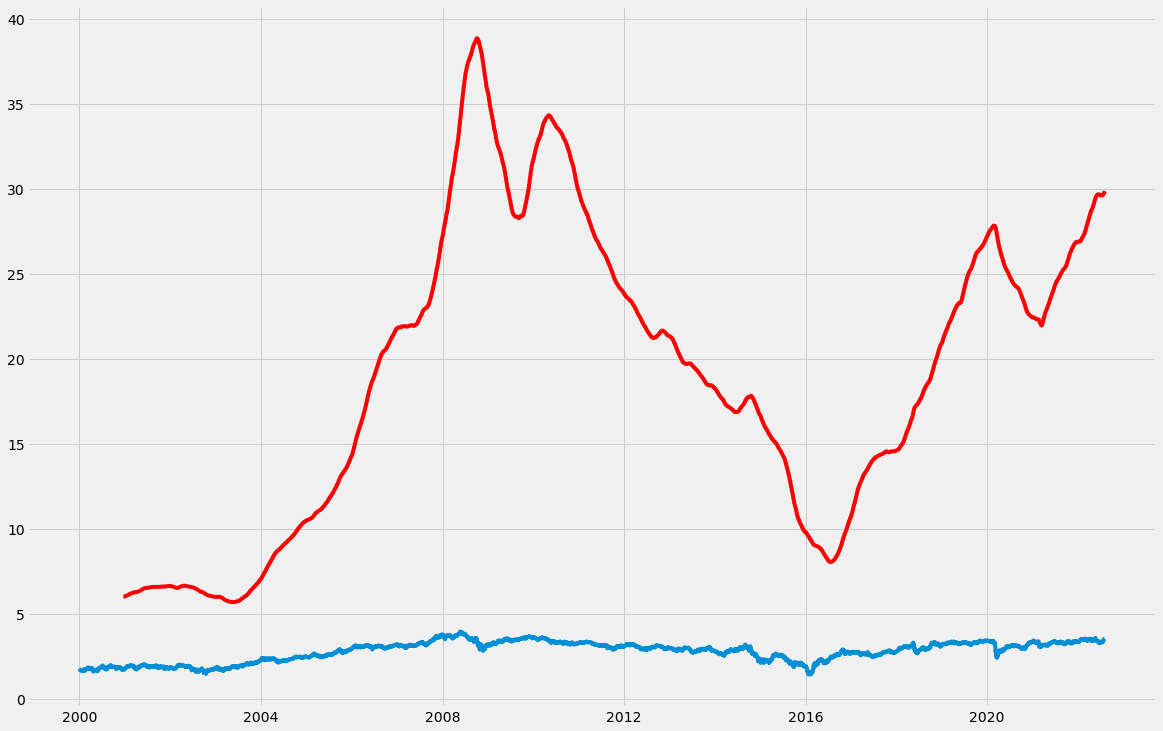

In [18]:
moving_avg = petr.rolling(252).mean()
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

In [19]:
ts_log_moving_avg_diff = ts_log - moving_avg
ts_log_moving_avg_diff.head(12)

,PETR4 (R$)
data,
2000-01-03,NaN
2000-01-04,NaN
2000-01-05,NaN
2000-01-06,NaN
2000-01-07,NaN
2000-01-10,NaN
2000-01-11,NaN
2000-01-12,NaN
2000-01-13,NaN


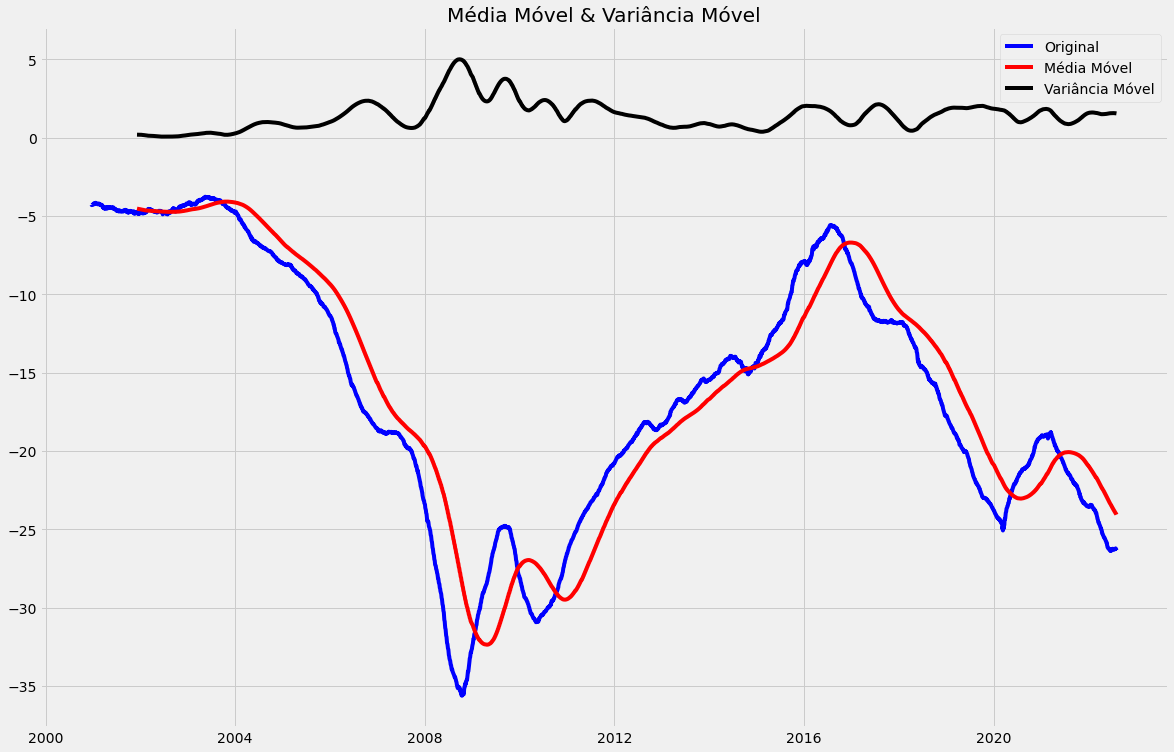

Results of Dickey-Fuller Test:
Test Statistic                   -2.087860
p-value                           0.249424
#Lags Used                       28.000000
Number of Observations Used    5397.000000
Critical Value (1%)              -3.431562
Critical Value (5%)              -2.862076
Critical Value (10%)             -2.567055
dtype: float64


In [20]:
ts_log_moving_avg_diff.dropna(inplace=True)
test_stationarity(ts_log_moving_avg_diff)

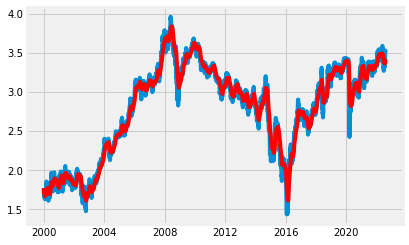

In [ ]:
expwighted_avg = ts_log.ewm(halflife=12).mean()
plt.plot(ts_log)
plt.plot(expwighted_avg, color='red')

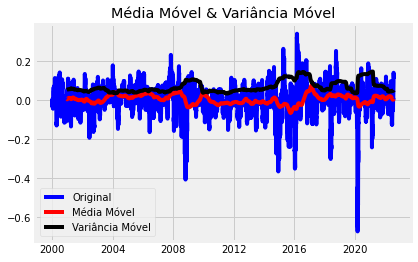

Results of Dickey-Fuller Test:
Test Statistic                -1.188616e+01
p-value                        6.016712e-22
#Lags Used                     7.000000e+00
Number of Observations Used    5.669000e+03
Critical Value (1%)           -3.431504e+00
Critical Value (5%)           -2.862050e+00
Critical Value (10%)          -2.567041e+00
dtype: float64


In [ ]:
ts_log_ewma_diff = ts_log - expwighted_avg 
test_stationarity(ts_log_ewma_diff)

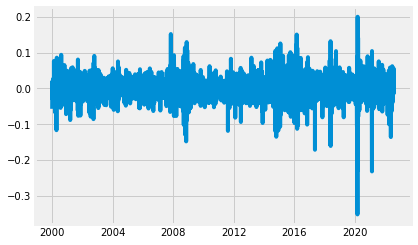

In [ ]:
ts_log_diff = ts_log - ts_log.shift()
plt.plot(ts_log_diff)

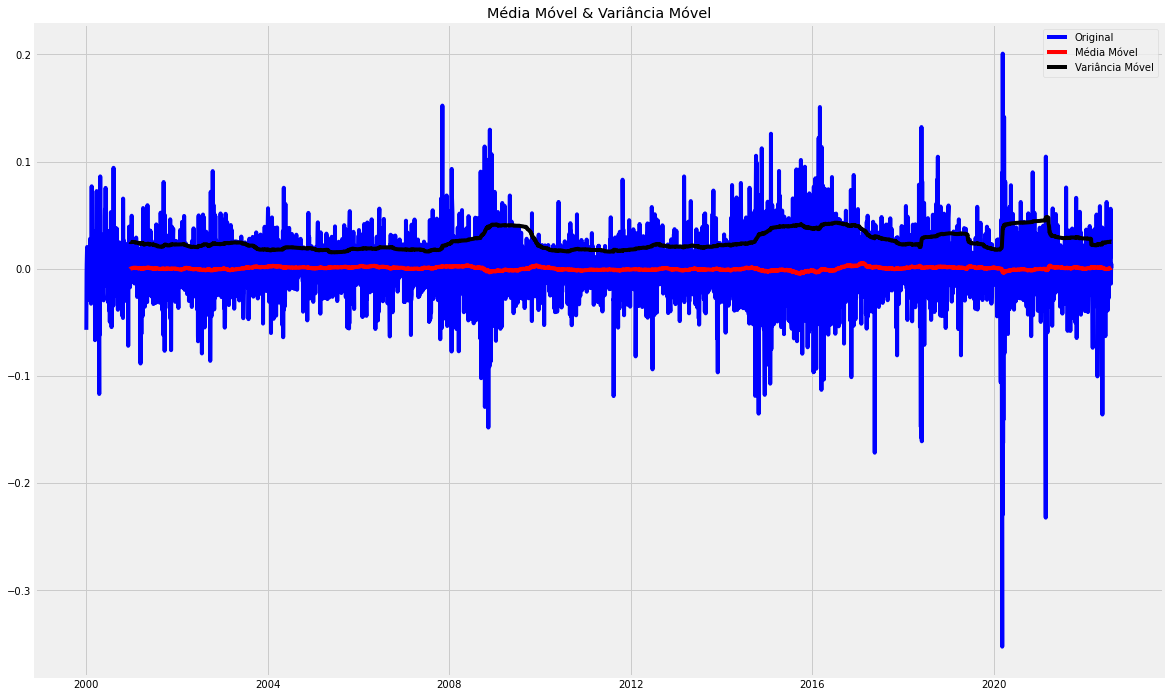

Results of Dickey-Fuller Test:
Test Statistic                  -27.488936
p-value                           0.000000
#Lags Used                        6.000000
Number of Observations Used    5669.000000
Critical Value (1%)              -3.431504
Critical Value (5%)              -2.862050
Critical Value (10%)             -2.567041
dtype: float64


In [ ]:
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)

Previsão

In [ ]:
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf

lag_acf = acf(ts_log_diff, nlags=20)
lag_pacf = pacf(ts_log_diff, nlags=20, method='ols')

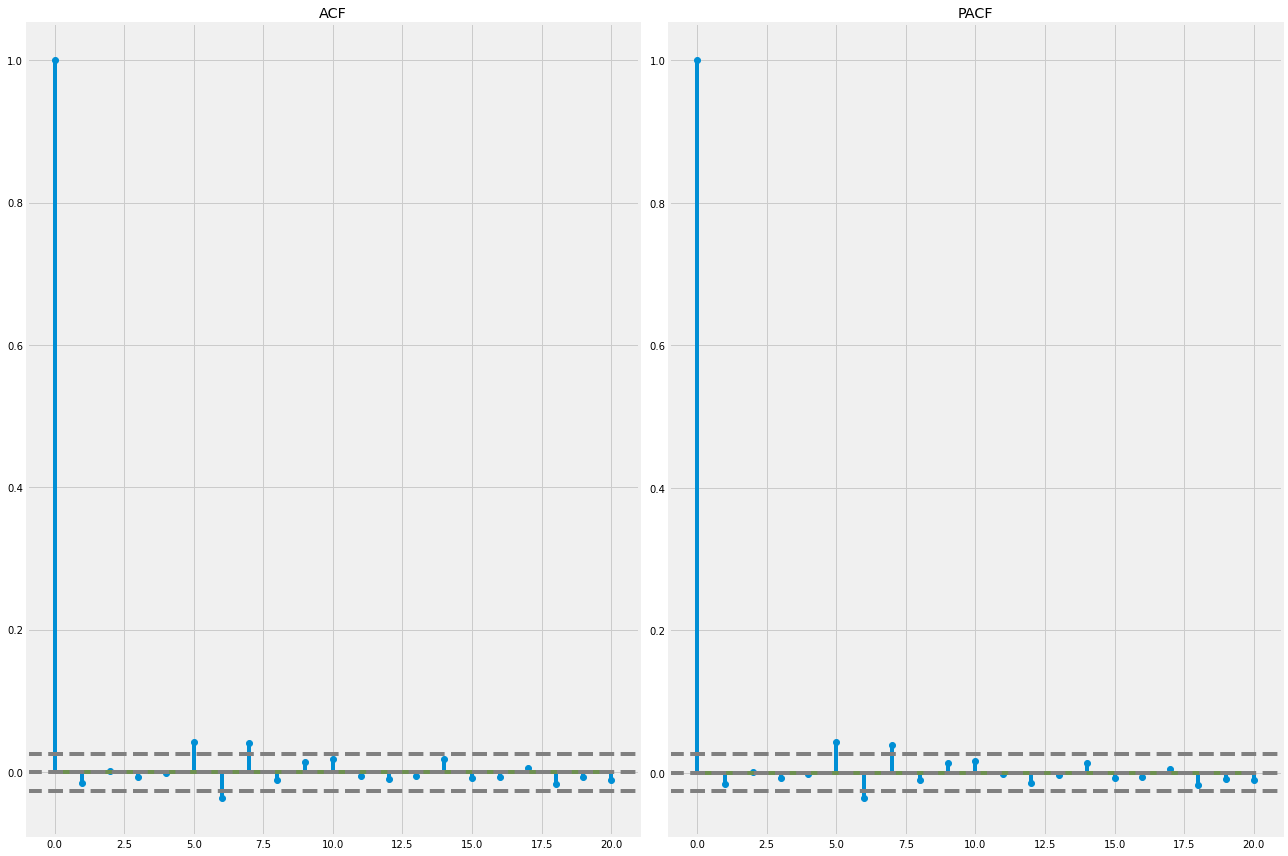

In [ ]:
#Plot ACF: 
plt.subplot(121) 
plt.stem(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('ACF')

#Plot PACF: 
plt.subplot(122)
plt.stem(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray') 
plt.title('PACF') 
plt.tight_layout()

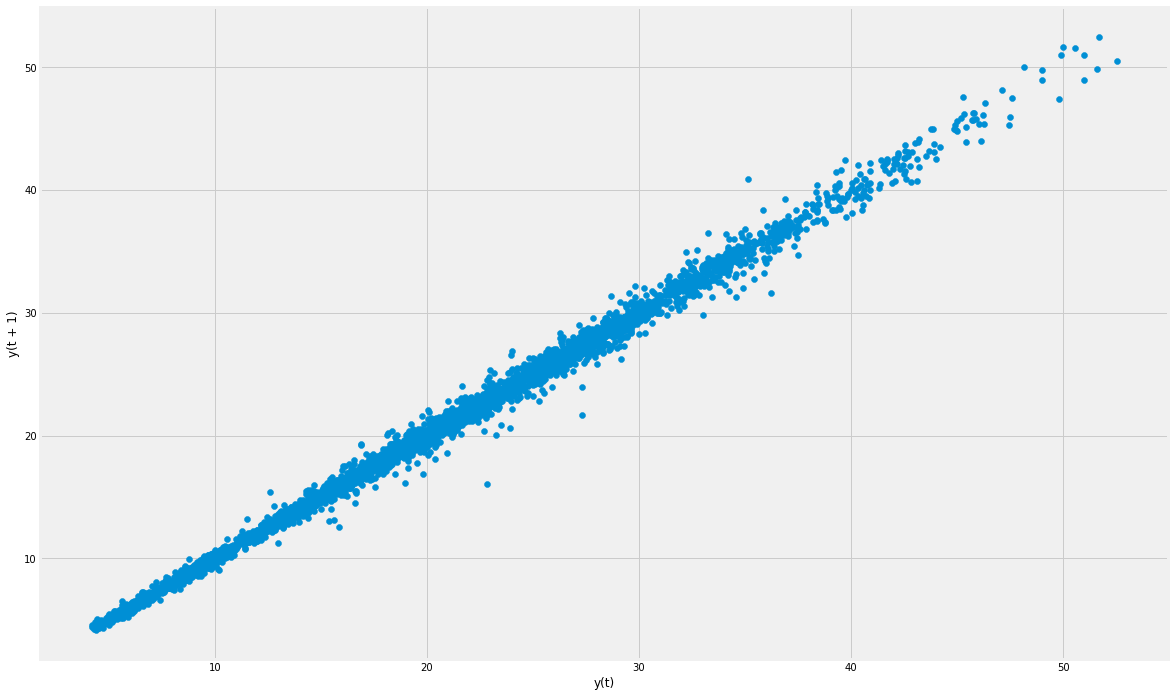

In [ ]:
from matplotlib import pyplot
from pandas.plotting import lag_plot

lag_plot(petr)
pyplot.show()

In [ ]:
values = pd.DataFrame(petr.values)
dataframe = pd.concat([values.shift(1), values], axis=1)
dataframe.columns = ['t-1', 't+1']
result = dataframe.corr()
print(result)

          t-1       t+1
t-1  1.000000  0.998386
t+1  0.998386  1.000000


In [ ]:
from pandas.plotting import autocorrelation_plot

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

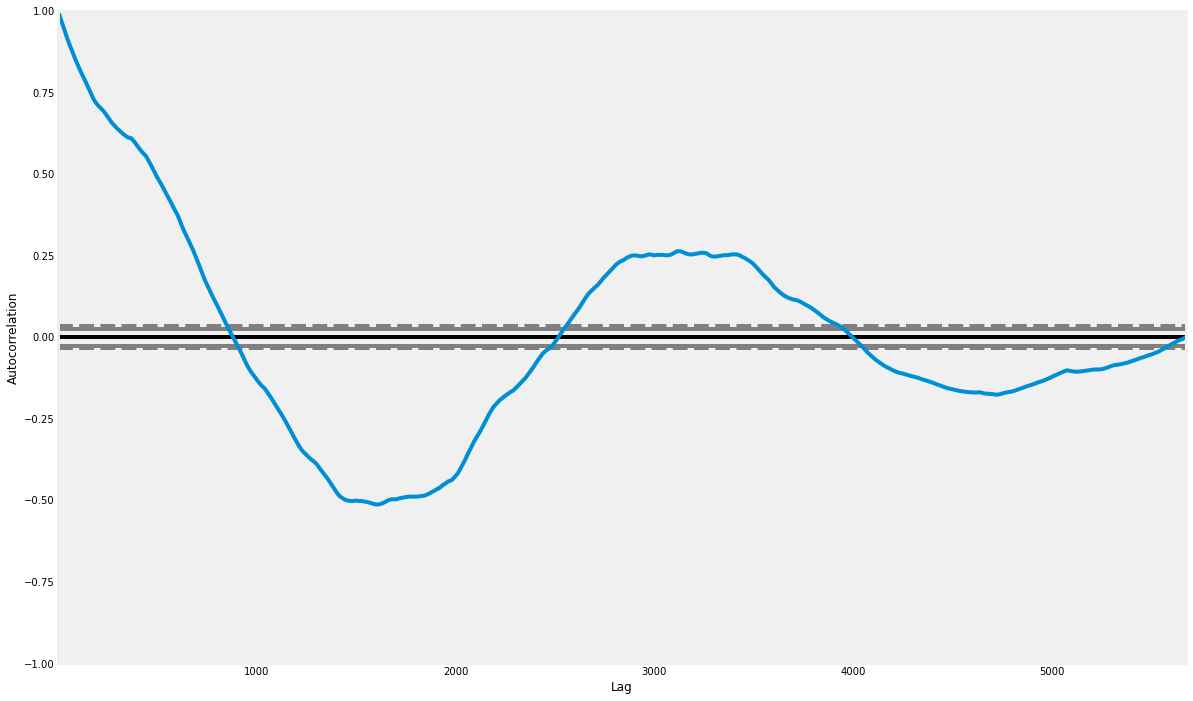

In [ ]:
autocorrelation_plot(petr)

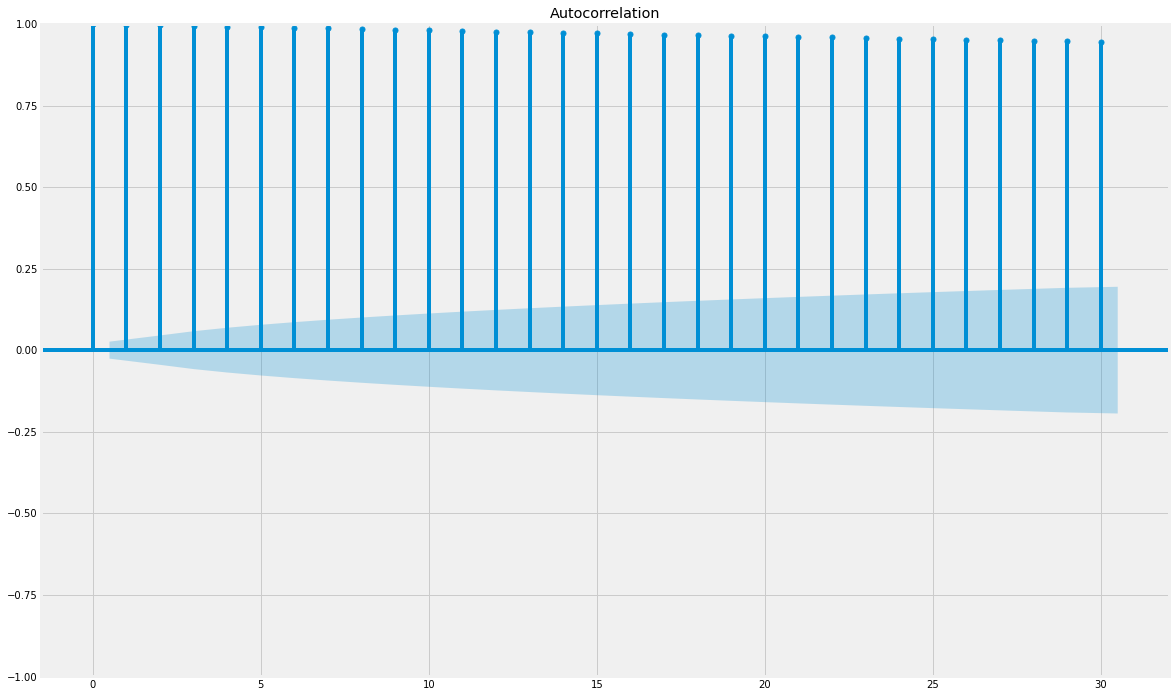

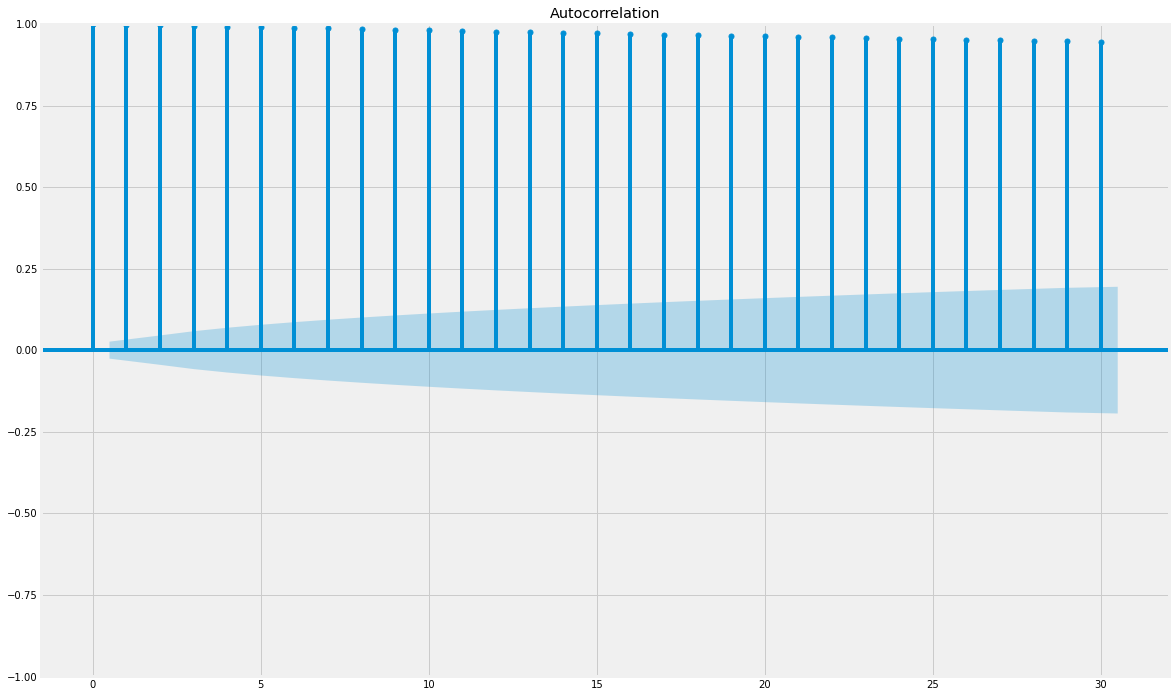

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(petr, lags=30)

In [ ]:
petr

,PETR4 (R$)
data,
2000-01-03,5.875000
2000-01-04,5.550000
2000-01-05,5.494000
2000-01-06,5.475000
2000-01-07,5.500000
...,...
2022-07-29,34.150002
2022-08-01,33.680000
2022-08-02,33.830002


In [33]:
from statsmodels.tsa.ar_model import AutoReg

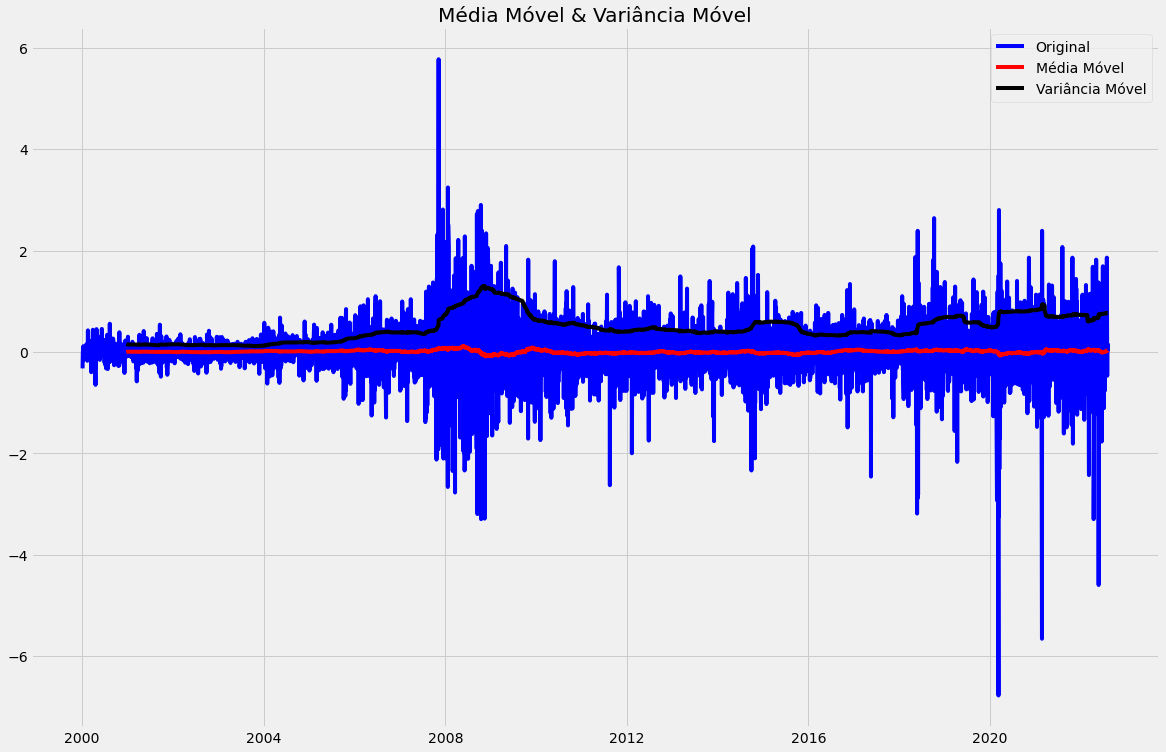

Results of Dickey-Fuller Test:
Test Statistic                -1.223349e+01
p-value                        1.040742e-22
#Lags Used                     3.100000e+01
Number of Observations Used    5.644000e+03
Critical Value (1%)           -3.431509e+00
Critical Value (5%)           -2.862052e+00
Critical Value (10%)          -2.567043e+00
dtype: float64


In [41]:
#DIFERENCIAR SÉRIE TEMPORAL
petr_diff = petr.diff(1)
petr_diff.dropna(inplace=True)
test_stationarity(petr_diff)

In [42]:

#
# Instantiate and fit the AR model with training data
#
ar_model = AutoReg(petr_diff, lags=252).fit()
#
# Print Summary
#
print(ar_model.summary())

/home/matheus/miniconda3/envs/econometria/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                            AutoReg Model Results                             
Dep. Variable:             PETR4 (R$)   No. Observations:                 5676
Model:                   AutoReg(252)   Log Likelihood               -4268.901
Method:               Conditional MLE   S.D. of innovations              0.532
Date:                Thu, 04 Aug 2022   AIC                           9045.803
Time:                        20:47:47   BIC                          10721.844
Sample:                           252   HQIC                          9630.814
                                 5676                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0073      0.007      0.992      0.321      -0.007       0.022
PETR4 (R$).L1   -4.191e-05      0.014     -0.003      0.998      -0.027       0.027
PETR4 (R$).L2      -0.0145      

In [45]:
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA

<AxesSubplot:xlabel='data'>

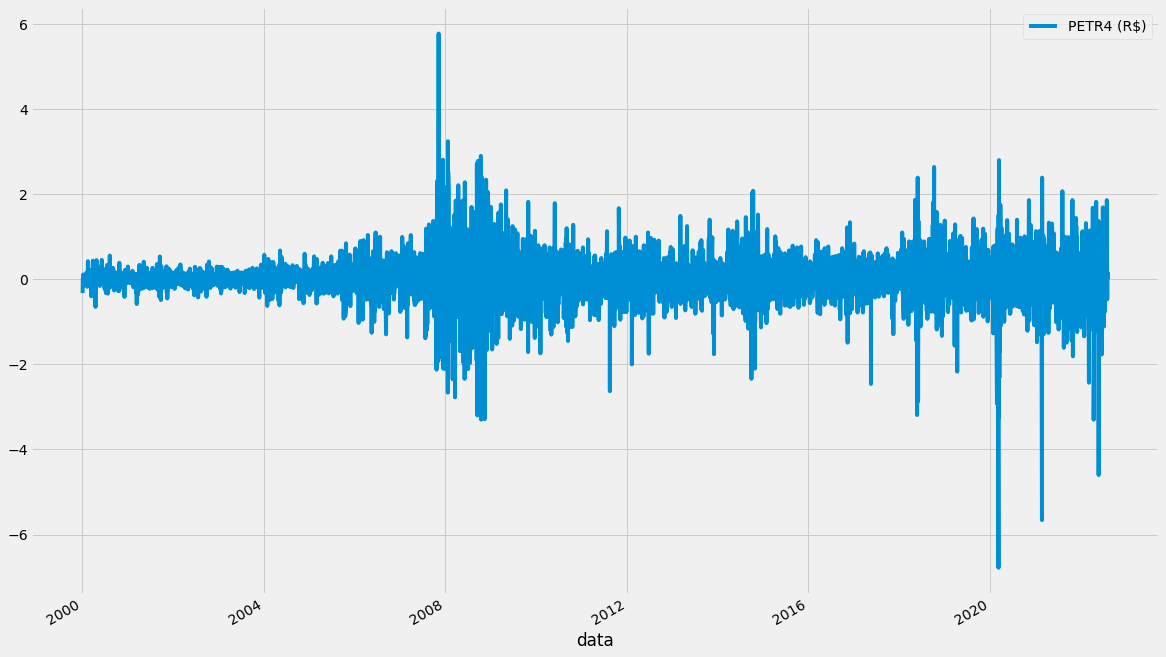

In [174]:
petr_diff.plot()

In [173]:
# Auto ARIMA nos ajuda a buscar os melhores parâmetros
fit_arima = auto_arima(petr_diff, d=1, start_p=1, start_q=1, max_p=3, max_q=3,
                    seasonal=True, 
                           m=6, 
                           D=1, 
                           start_P=1, 
                           start_Q=1, 
                           max_P=2, 
                           max_Q=2, 
                           information_criterion='aic',
                           trace=True, 
                           error_action='ignore', 
                           stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[6]             : AIC=inf, Time=5.39 sec
 ARIMA(0,1,0)(0,1,0)[6]             : AIC=17317.930, Time=0.22 sec
 ARIMA(1,1,0)(1,1,0)[6]             : AIC=14059.062, Time=0.95 sec
 ARIMA(0,1,1)(0,1,1)[6]             : AIC=inf, Time=8.39 sec
 ARIMA(1,1,0)(0,1,0)[6]             : AIC=15703.605, Time=0.35 sec
 ARIMA(1,1,0)(2,1,0)[6]             : AIC=13344.195, Time=1.67 sec
 ARIMA(1,1,0)(2,1,1)[6]             : AIC=inf, Time=11.55 sec
 ARIMA(1,1,0)(1,1,1)[6]             : AIC=inf, Time=4.74 sec
 ARIMA(0,1,0)(2,1,0)[6]             : AIC=14928.236, Time=1.05 sec
 ARIMA(2,1,0)(2,1,0)[6]             : AIC=12710.457, Time=1.90 sec
 ARIMA(2,1,0)(1,1,0)[6]             : AIC=13414.728, Time=1.29 sec
 ARIMA(2,1,0)(2,1,1)[6]             : AIC=inf, Time=17.19 sec
 ARIMA(2,1,0)(1,1,1)[6]             : AIC=inf, Time=6.96 sec
 ARIMA(3,1,0)(2,1,0)[6]             : AIC=12223.498, Time=2.97 sec
 ARIMA(3,1,0)(1,1,0)[6]             : AIC=12907.243, 

In [175]:
model = ARIMA(petr,order=(0,1,0),  seasonal_order=(2,1,0,6))
resultado_arima = model.fit()

/home/matheus/miniconda3/envs/econometria/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/matheus/miniconda3/envs/econometria/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/matheus/miniconda3/envs/econometria/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [176]:
resultado_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    SARIMAX Results                                    
=======================================================================================
Dep. Variable:                      PETR4 (R$)   No. Observations:                 5677
Model:             ARIMA(0, 1, 0)x(2, 1, 0, 6)   Log Likelihood               -5478.886
Date:                         Thu, 04 Aug 2022   AIC                          10963.771
Time:                                 21:21:10   BIC                          10983.700
Sample:                                      0   HQIC                         10970.712
                                        - 5677                                         
Covariance Type:                           opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L6       -0.6631      0.007    -98.589      0.000      -0.676      -0.650
ar.S.L12      -0.3380      0.006    -53.425      0.000      -0.350      -0.326
sigma2         0.4042      0.003    136.150      0.000       0.398       0.410
===================================================================================
Ljung-Box (L1) (Q):                   0.26   Jarque-Bera (JB):             32046.53
Prob(Q):                              0.61   Prob(JB):                         0.00
Heteroskedasticity (H):               6.75   Skew:                            -0.45
Prob(H) (two-sided):                  0.00   Kurtosis:                        14.61
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Predição (Para trás)

In [177]:
# Vamos realizar um "backtesting" com predições de valores dos 12 meses anteriores
predicoes = resultado_arima.get_prediction(start=-252)
predicao_media = predicoes.predicted_mean

In [178]:
# intervalo de confiança

intervalo_confianca = predicoes.conf_int()
limites_abaixo = intervalo_confianca.iloc[:,0]
limites_acima = intervalo_confianca.iloc[:,1]

limites_abaixo[0], limites_acima[0]

(25.40823461996463, 27.900374785135938)

In [179]:
predicao_media[0]

26.654304702550284

In [180]:
datas_previsao = np.asarray(predicao_media.index)
datas = np.asarray(petr.index)

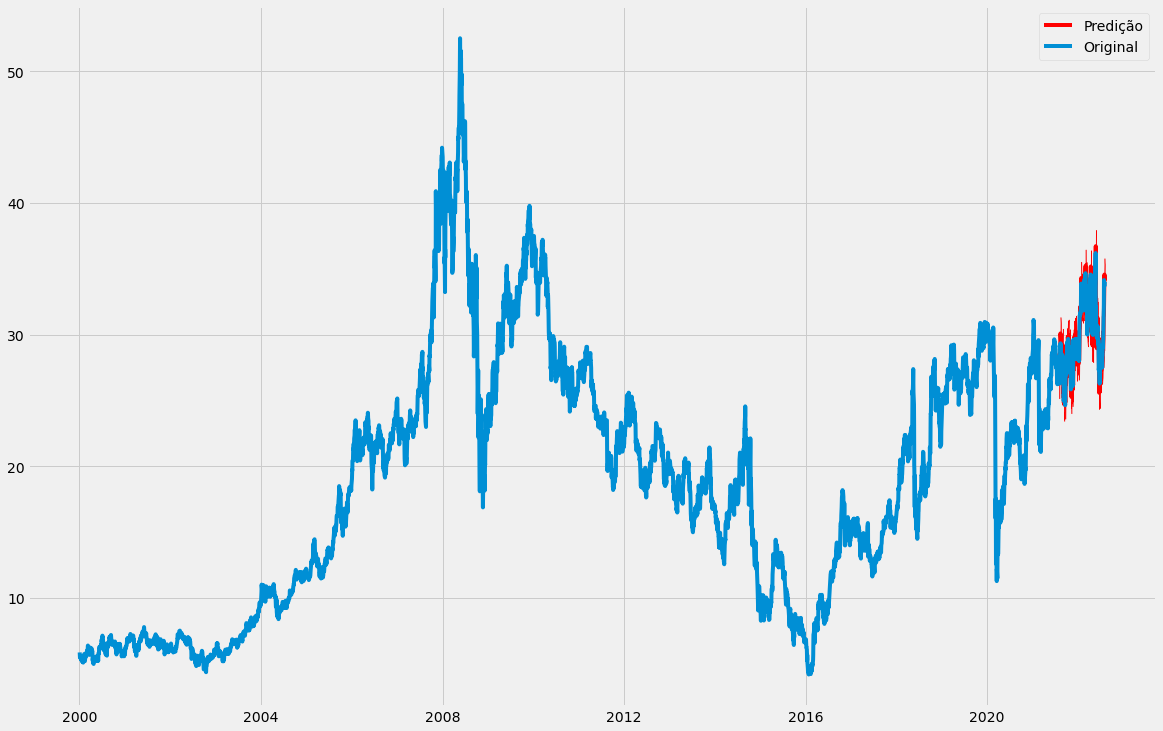

In [181]:

plt.plot(datas_previsao,predicao_media.values,color='red',label='Predição')
plt.plot(datas, petr.values, label='Original')
plt.fill_between(datas_previsao, limites_abaixo, limites_acima, color='red')
plt.legend()
plt.show()

Predição (Para frente)

In [196]:
forecast = resultado_arima.get_forecast(steps=8197)
forecast_medio = forecast.predicted_mean
forecast_medio.size

/home/matheus/miniconda3/envs/econometria/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


8197

In [187]:
intervalo_confianca_forecast = forecast.conf_int()
intervalo_abaixo_f = intervalo_confianca_forecast.iloc[:,0]
intervalo_acima_f = intervalo_confianca_forecast.iloc[:,1]

intervalo_abaixo_f[5925], intervalo_acima_f[5925]

AttributeError: 'Series' object has no attribute 'conf_int'

In [188]:
intervalo_confianca_forecast

,lower PETR4 (R$),upper PETR4 (R$)
5677,32.941973,35.434114
5678,33.010378,36.534797
5679,32.299898,36.616411
5680,32.620830,37.605110
5681,32.650531,38.223126
...,...,...
13869,-41533.253820,47448.120674
13870,-41540.783264,47456.866788
13871,-41548.698730,47465.223903
13872,-41556.537944,47473.654297


In [189]:
forecast_medio[8197]

933.4263203671924

In [190]:
len(petr) + 2520

8197

In [191]:
forecast_medio

5925    122.553997
5926    123.162332
5927    123.383156
5928    123.678746
5929    124.072525
           ...    
8193    931.907792
8194    932.516127
8195    932.736951
8196    933.032541
8197    933.426320
Name: predicted_mean, Length: 2273, dtype: float64

In [192]:
datas_forecast = np.asarray(forecast_medio.index)
pred_dates=np.asarray(predicao_media.index)

ValueError: x and y must have same first dimension, but have shapes (2273,) and (8197,)

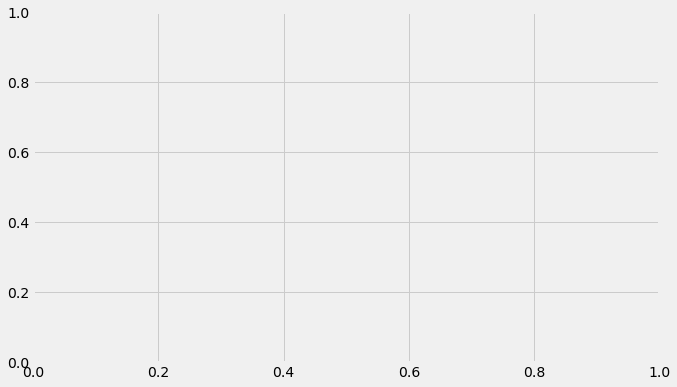

In [199]:
dates=np.asarray(petr.index)
plt.figure(figsize=(10,6))
plt.plot(datas_forecast,forecast_medio.values,color='green',label='forecast')
plt.fill_between(datas_forecast, intervalo_abaixo_f, intervalo_acima_f, color='lightgreen')

plt.plot(datas_previsao,predicao_media.values,color='red',label='prediction')
plt.fill_between(datas_previsao, limites_abaixo, limites_acima, color='pink')

plt.plot(dates,res.values, label='real')
plt.legend(loc='upper left')
plt.show()

In [212]:
from prophet import Prophet

/home/matheus/miniconda3/envs/econometria/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [236]:
df = petr.reset_index()

In [237]:
df.columns = ['ds','y']

In [238]:
m = Prophet()
m.fit(df)

21:39:38 - cmdstanpy - INFO - Chain [1] start processing
21:39:44 - cmdstanpy - INFO - Chain [1] done processing


In [239]:
df

,ds,y
0,2000-01-03,5.875000
1,2000-01-04,5.550000
2,2000-01-05,5.494000
3,2000-01-06,5.475000
4,2000-01-07,5.500000
...,...,...
5672,2022-07-29,34.150002
5673,2022-08-01,33.680000
5674,2022-08-02,33.830002
5675,2022-08-03,33.849998


In [240]:
future = m.make_future_dataframe(periods=2520)
future.tail()

,ds
8192,2029-06-24
8193,2029-06-25
8194,2029-06-26
8195,2029-06-27
8196,2029-06-28


In [241]:
# Python
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
8192,2029-06-24,46.815852,-4.413413,97.348003
8193,2029-06-25,46.981043,-2.734140,97.745063
8194,2029-06-26,46.958368,-4.477910,97.460896
8195,2029-06-27,46.988573,-4.321566,96.803390
8196,2029-06-28,46.975523,-4.165568,97.521399


<AxesSubplot:xlabel='ds'>

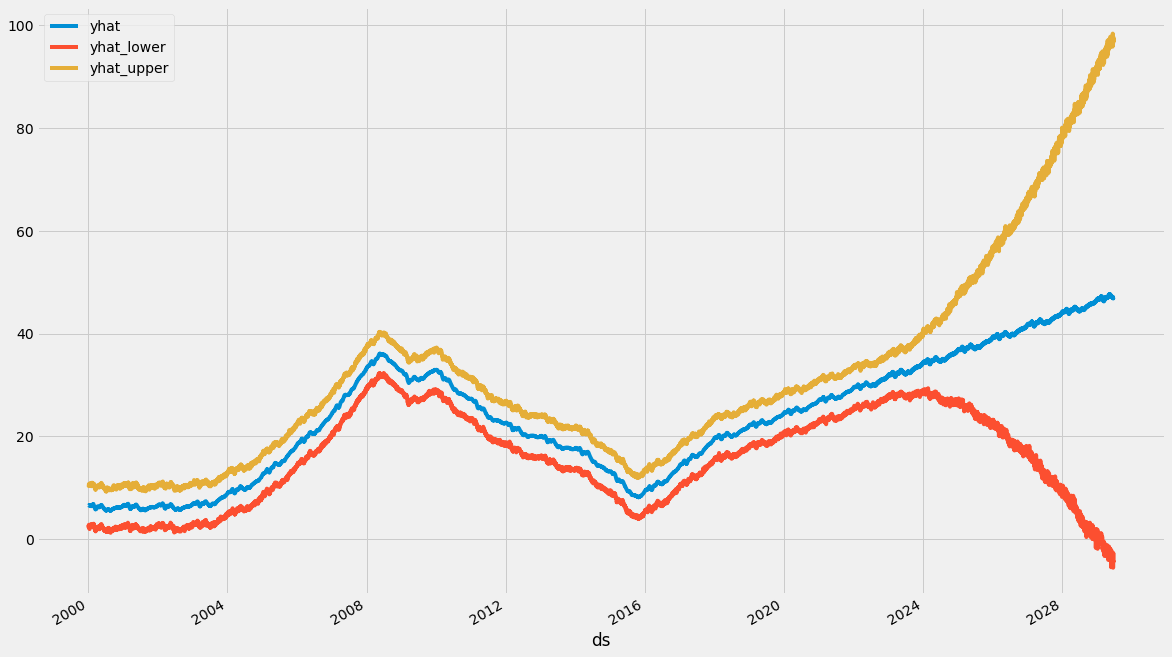

In [249]:
forecast.set_index('ds')[['yhat', 'yhat_lower','yhat_upper']].plot()

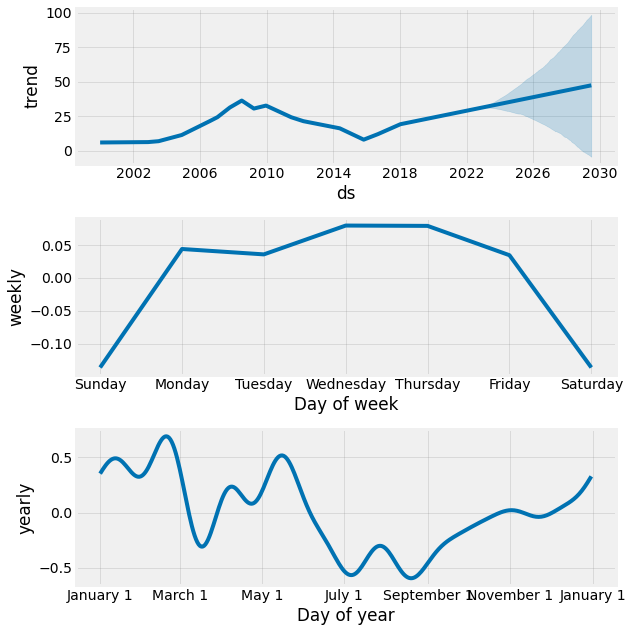

In [243]:
fig2 = m.plot_components(forecast)